In [1]:
#Packages import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import TessTargetPixelFile
import math
import astropy.units as u

Note: Comments in this notebook are written just after the number sign #, which helps distinguish the real code from the comments. You can delete them if you want.

In [2]:
# Search for your target using its TIC ID 
TIC = 'TIC 176220787' #This is WASP-136b

In [3]:
# Check the availability of the data for this target
available_data_all = lk.search_lightcurve(TIC, mission = 'TESS')

In [4]:
available_data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,SPOC,20,176220787,0.0
1,TESS Sector 29,2020,SPOC,120,176220787,0.0
2,TESS Sector 29,2020,TESS-SPOC,600,176220787,0.0
3,TESS Sector 29,2020,QLP,600,176220787,0.0
4,TESS Sector 42,2021,SPOC,120,176220787,0.0


In [5]:
# Select multiple sectors based on the available data above.
select_sectors = available_data_all[0:42]

In [6]:
# Download and illustrate multiple sectors.
collect_lc = select_sectors.download_all()

<IPython.core.display.Javascript object>


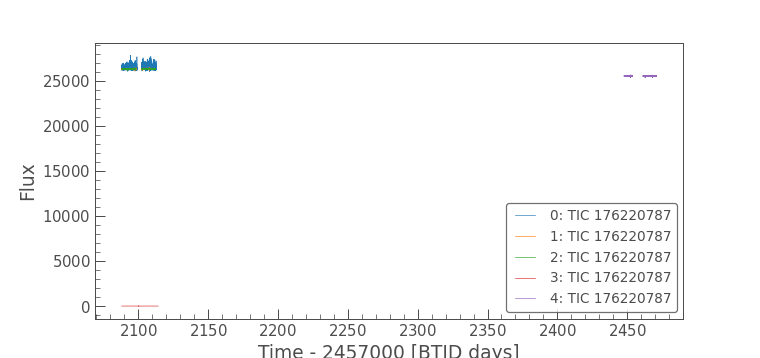

/home/orion/.local/lib/python3.8/site-packages/lightkurve/collections.py:263: LightkurveWarning: Some but not all of the light curves in the collection appear to be normalized. You may wish to use `normalize=True` to ensure all are normalized.
  warnings.warn(


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

In [7]:
collect_lc.plot()

In [8]:
# Stitch the different sectors together, this '.stitch()' function also normalized the data for us
collect_lc = collect_lc.stitch()

/home/orion/.local/lib/python3.8/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(


<IPython.core.display.Javascript object>


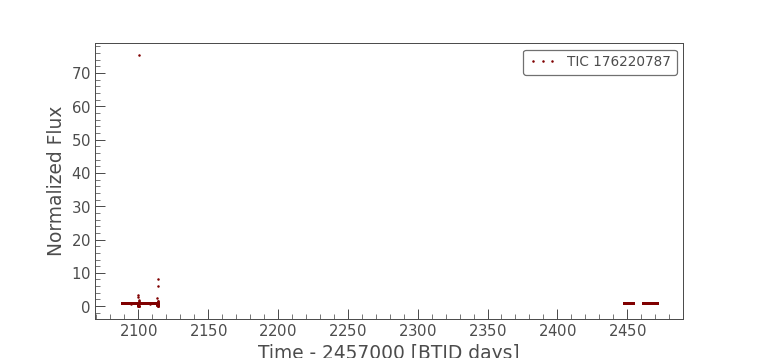

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [9]:
collect_lc.plot(color = 'maroon', lw = 0, marker = '.')

<IPython.core.display.Javascript object>


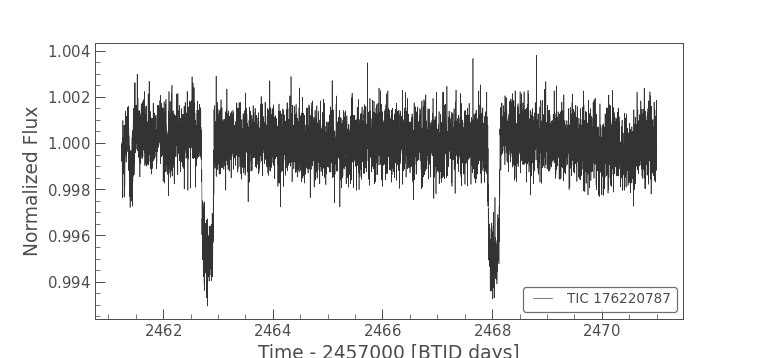

<IPython.core.display.Javascript object>


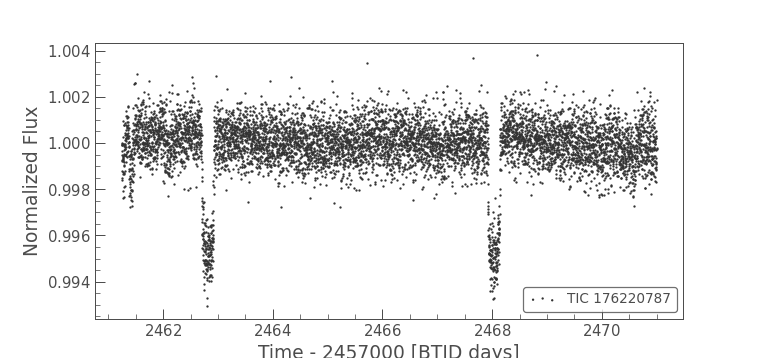

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [10]:
#Now we will mask our lightcurves retaining only the timeframe we want.
mask = ((collect_lc.time.value < 2471)&(collect_lc.time.value > 2461)) 
masked_lc=collect_lc[mask];
masked_lc.plot();
masked_lc.scatter(s=3)

<IPython.core.display.Javascript object>


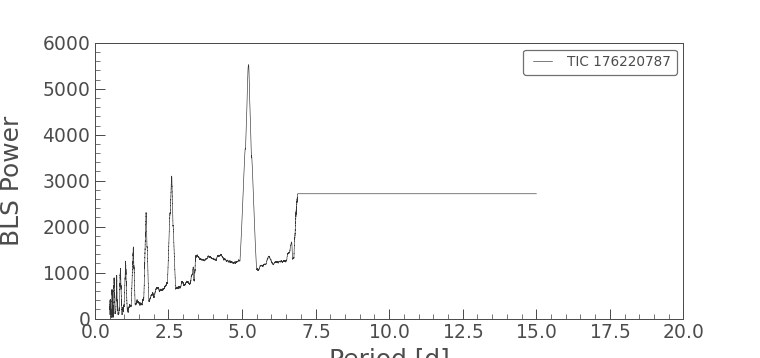

Period at max power = 5.2237422237422235 d
BLS max power = 5522.868550370486


In [11]:
#Here we use the Box Least Square method with a periodogram to search for periodic signals and calculate the exoplanet's period
import numpy as np
import matplotlib.pyplot as plt
period = np.linspace(0.5,15, 1000000) # (star,end,steps). You can change the start and end timeframe.
bls = masked_lc.to_periodogram(method='bls', period=period);
bls.plot();
plt.ylabel('BLS Power', fontsize=20, labelpad=15)
plt.xlabel('Period [d]', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#Limits on x and y axis are given manually. You may need to change them depedning on the timeframe given.
plt.xlim(0,20) 
plt.ylim([0,6000])

print('Period at max power =',bls.period_at_max_power)
print('BLS max power =', bls.max_power)

<IPython.core.display.Javascript object>


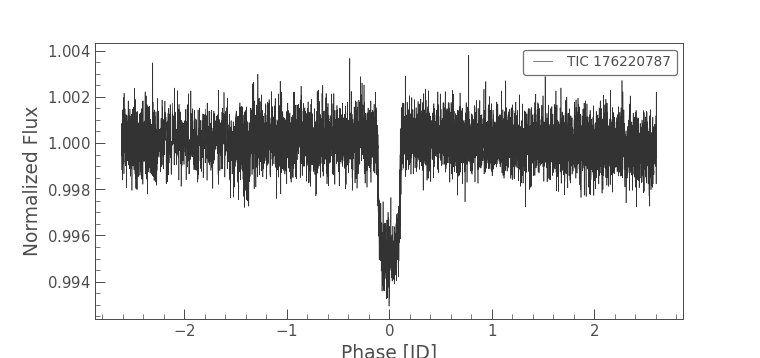

<IPython.core.display.Javascript object>


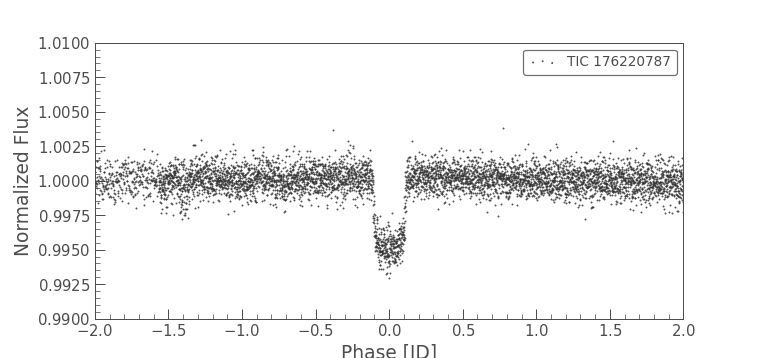

(0.99, 1.01)

In [12]:
#Here we will fold the lightcurve based on the period we found earlier and on the epoch time that period happens.
#After folding your light curve you should see a signal (transit) on phase 0.
folded_lc = masked_lc.fold(bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)
folded_lc.plot();
folded_lc.scatter(s=1)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-2,2)
plt.ylim([0.99,1.01])

<IPython.core.display.Javascript object>


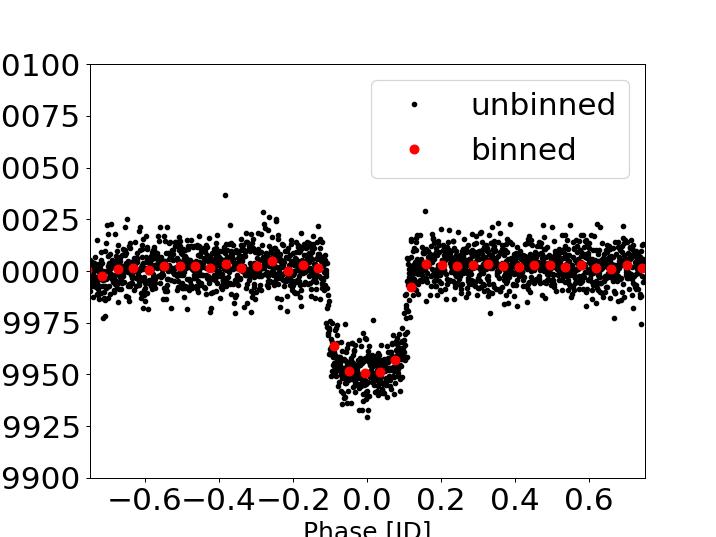

(0.99, 1.01)

In [13]:
period  = bls.period_at_max_power
t0 = bls.transit_time_at_max_power 

folded2_lc = masked_lc.fold(bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)

#Bin the folded lightcurve. Here we bin at 60 minutes.
folded2_lc_binned = folded_lc.bin(60/24/60)

fig, ax = plt.subplots(figsize = (8,6))

folded2_lc.plot(ax = ax, marker = '.', linewidth = 0, color = 'black', alpha = 1, markersize = 7)
folded2_lc_binned.plot(ax = ax, marker = 'o', linewidth = 0, color = 'red', alpha = 1, markersize = 7)
plt.legend(labels= ['unbinned', 'binned'], fontsize=25)
plt.ylabel('Flux [e ־s ־1]', fontsize=25, labelpad=15)
plt.xlabel('Phase [JD]', fontsize=20)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-0.75,0.75)
plt.ylim([0.99,1.01])

In [14]:
min = np.min(folded2_lc_binned.flux) #Minimum flux of the binned lightcurve
print('Minimum flux = ', min)
median = np.median(folded2_lc_binned.flux) #Median flux of the binned lightcurve. The median flux should be equal to 1.
print('median flux =', median)
Tdepth = 1 - min
print('Tdepth = ', Tdepth)
print('Tdepth in ppm = ', Tdepth * (10**6), 'ppm')
ratio = np.sqrt(Tdepth)
print('Rp/Rs ratio = ', ratio) #Exoplanet's radius and Star's radius ratio. 

Minimum flux =  0.995057225227356
median flux = 1.000077486038208
Tdepth =  0.004942774772644043
Tdepth in ppm =  4942.774772644043 ppm
Rp/Rs ratio =  0.07030487019150268


In [15]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

In [16]:
planet_b_period

<Quantity 5.22374222 d>

In [17]:
planet_b_t0

<Time object: scale='tdb' format='btjd' value=2462.8101965803257>

In [18]:
planet_b_dur
print('Transit duration in hours=', planet_b_dur*24, 'hours')

Transit duration in hours= 4.800000000000001 d hours


<IPython.core.display.Javascript object>


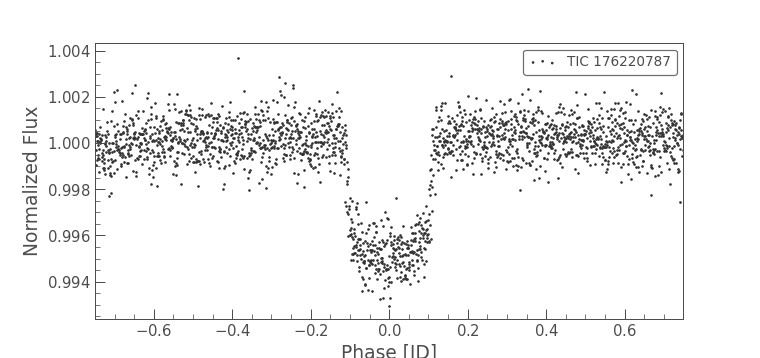

<IPython.core.display.Javascript object>


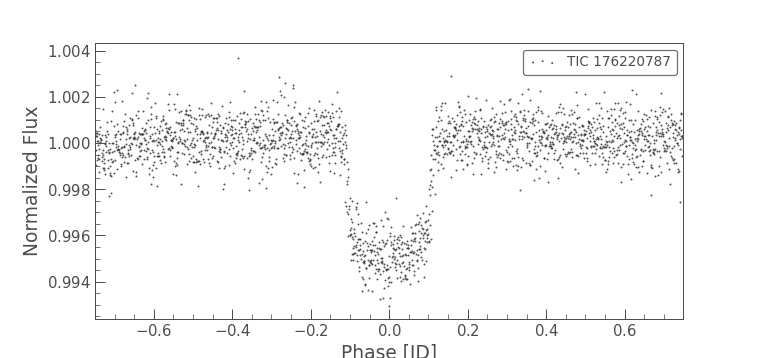

In [19]:
ax = masked_lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter(s=5);
ax.set_xlim(-0.75, 0.75);
ax2 = masked_lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter(s=1);
ax2.set_xlim(-0.75, 0.75);

In [20]:
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                     transit_time=planet_b_t0,
                                     duration=planet_b_dur)

<IPython.core.display.Javascript object>


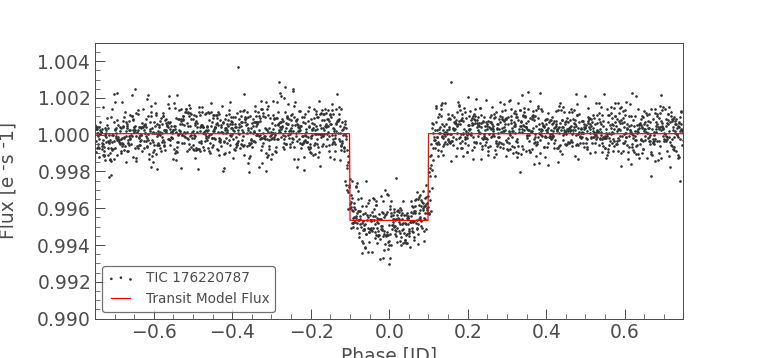

(0.99, 1.005)

In [21]:
#Here we apply a transit model on the masked lightcurve based on the period,transit time and transit duration.
ax = masked_lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter(s=5);
planet_b_model.fold(period=planet_b_period, epoch_time=planet_b_t0).plot(ax=ax, c='red', lw=1)
ax.set_xlim(-1, 1)
plt.ylabel('Flux [e ־s ־1]', fontsize=15, labelpad=15)
plt.xlabel('Phase [JD]', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-0.75,0.75)
plt.ylim([0.99,1.005])

In [22]:
print(bls.period_at_max_power)
print(bls.transit_time_at_max_power)
print(bls.duration_at_max_power)

5.2237422237422235 d
2462.8101965803257
0.2 d


# Exoplanet properties calculations
Search the target's TIC ID at https://exofop.ipac.caltech.edu/tess/ to get the star's properties needed for the calculations below.

In [23]:
P = 5.2237422237422235 * 24 * 60 * 60 #planet's period
G = 6.674* 10 ** -11 #gravitational constant
M = 1.13 * 1.98847 * 10**30 #Star's mass
pi = math.pi
a = ((P**2)/((4*pi**2)/(G*M)))**(1/3) #Orbital radius or semi-major axis
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')

Orbital Radius
a = 9180612090.96863 m
a = 9180612.09096863 km
a = 0.061368600235331715 AU
The planetary mass was neglected


In [24]:
L = 6.974175 #Star's luminosity
ri= (L/1.1)**(1/2)
ro= (L/0.53)**(1/2)
print('Habitable Zone')
print('The inner boundary of the habitable zone ri =', ri, 'AU')
print('The outer boundary of the habitable zone ro =', ro, 'AU')

Habitable Zone
The inner boundary of the habitable zone ri = 2.5179672537404234 AU
The outer boundary of the habitable zone ro = 3.6275088910596733 AU


In [25]:
Rs = 2.39014 #Star's radius
Transit_depth = Tdepth
Rsun  = 696340 #Sun radius
Rearth = 6371 #Earth radius
Rp = (Rs * Transit_depth ** (1/2)) * Rsun #Exoplanet's radius
print('Planet Radius')
print('Rp =', Rp, 'km')
print('Rp=',Rp/Rearth, 'Rearth')
aRs = (a/1000)/(Rs*Rsun)
print('Orbital Period and Star Radius ratio')
print('a/Rs', aRs)

Planet Radius
Rp = 117011.91686193412 km
Rp= 18.366334462711368 Rearth
Orbital Period and Star Radius ratio
a/Rs 5.516034252269071


In [26]:
P = 5.2237422237422235 * 24 * 60 * 60
pi = math.pi
a = 9180612090.96863 #semi-major axis in meters
v = (2*pi*a/P)
print('Planet Velocity')
print('v =',v , 'm/s')

Planet Velocity
v = 127807.40756401613 m/s


*** Summing up all calculated properties ***

In [27]:
print('Period = ',bls.period_at_max_power)
print('Transit duration in hours planet disk fully superimposed to the stellar disk Tf = ', bls.duration_at_max_power*24,'hours')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Transit depth = ', Tdepth)
print('Transit depth in ppm = ', Tdepth * (10**6), 'ppm')
ratio = np.sqrt(Tdepth)
print('Rp/Rs ratio = ', ratio)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Radius')
print('Rp =', Rp, 'km')
print('Rp=',Rp/Rearth, 'Rearth')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Period and Star Radius ratio')
print('a/Rs', aRs)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Velocity')
print('v =',v , 'm/s')
print('- - - - - - - - - - - - - - - - - - - - ')


Period =  5.2237422237422235 d
Transit duration in hours planet disk fully superimposed to the stellar disk Tf =  4.800000000000001 d hours
- - - - - - - - - - - - - - - - - - - - 
Transit depth =  0.004942774772644043
Transit depth in ppm =  4942.774772644043 ppm
Rp/Rs ratio =  0.07030487019150268
- - - - - - - - - - - - - - - - - - - - 
Planet Radius
Rp = 117011.91686193412 km
Rp= 18.366334462711368 Rearth
- - - - - - - - - - - - - - - - - - - - 
Orbital Radius
a = 9180612090.96863 m
a = 9180612.09096863 km
a = 0.061368600235331715 AU
The planetary mass was neglected
- - - - - - - - - - - - - - - - - - - - 
Orbital Period and Star Radius ratio
a/Rs 5.516034252269071
- - - - - - - - - - - - - - - - - - - - 
Planet Velocity
v = 127807.40756401613 m/s
- - - - - - - - - - - - - - - - - - - - 


In [28]:
#Calculation of total transit duration Tt
Tt = ((((4 * period **(2) * Tdepth ** (1/2))/(math.pi ** 2)) * (((Rs*Rsun)/(a/1000))**(2))) + (planet_b_dur ** (2))) ** (1/2)
print('Total transit duration Tt =', Tt)
print('Tt in hours =', Tt * 24, 'hours')
#Calculation of the impact parameter b
b = (( ((1-(Tdepth **(1/2)))**(2)-(planet_b_dur/Tt)**(2))* (1+(Tdepth **(1/2)))**(2)  ) / (1 - (planet_b_dur/Tt)**(2) ) ) ** (1/2)
print('Impart parameter b=', b)
#Calculation of inclination
i = math.acos(b*(Rs*Rsun)/(a/1000))
print('Inclination i=', 90 - i, 'deg')

Total transit duration Tt = 0.2560347324619091 d
Tt in hours = 6.144833579085819 d hours
Impart parameter b= 0.8642140343982138
Inclination i= 88.58652489225537 deg


In [29]:
lk.show_citation_instructions()